# Base model development

Create an oracle model that set the base line for next steps

In [170]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
from model_class import CatBoostXT_BAG

In [172]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [196]:
import shap
import matplotlib.pyplot as plt

## LOAD DATA

In [5]:
data_dir = r'E:\Project\Dissertation'

In [7]:
df_features = pd.read_parquet(rf'{data_dir}\data\processed\final_df.parquet').reset_index(drop=True)
df_features = df_features.replace({None: np.nan})

df_app = pd.read_csv(rf'{data_dir}\home-credit-default-risk\application_train.csv').reset_index(drop=True)

In [8]:
df = df_app.merge(df_features, on='SK_ID_CURR', how='left')

In [9]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bb_w24_status_2_share__sum,bb_w24_status_3_share__mean,bb_w24_status_3_share__max,bb_w24_status_3_share__sum,bb_w24_status_4_share__mean,bb_w24_status_4_share__max,bb_w24_status_4_share__sum,bb_w24_status_5_share__mean,bb_w24_status_5_share__max,bb_w24_status_5_share__sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [28]:
# separate features, target
list_features = [col for col in df.columns if col not in ['TARGET','SK_ID_CURR']]
# features that starts with EXT_
list_ext_features = [col for col in df.columns if col.startswith('EXT_')]
# list ethical features
list_ethical_features = [col for col in df.columns if 'GENDER' in col]
# list categorical features
list_cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
list_cat_features = list(set(list_cat_features)-set(list_ethical_features))


list_key = ['SK_ID_CURR']
label_col = 'TARGET'

In [29]:
list_ext_features

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_MIN',
 'EXT_MAX',
 'EXT_MEAN',
 'EXT_STD',
 'EXT_VAR',
 'EXT_SPAN']

In [30]:
list_ethical_features

['CODE_GENDER']

In [31]:

list_cat_features

['OCCUPATION_TYPE',
 'w90_last_loan_type',
 'NAME_HOUSING_TYPE',
 'w360_last_loan_type',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'w30_last_loan_type',
 'HOUSETYPE_MODE',
 'w180_last_loan_type',
 'EMERGENCYSTATE_MODE',
 'FONDKAPREMONT_MODE',
 'NAME_TYPE_SUITE',
 'ORGANIZATION_TYPE',
 'FLAG_OWN_CAR',
 'WALLSMATERIAL_MODE',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_CONTRACT_TYPE',
 'w720_last_loan_type']

In [32]:
df[list_cat_features] = df[list_cat_features].fillna('Missing')

In [33]:
long_list = list(set(list_features)-set(list_ext_features)-set(list_ethical_features))
len(long_list)

576

In [34]:
df_long = df[list_key + [label_col] + long_list]

In [35]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(df_long[long_list], df_long[label_col], test_size=0.25, random_state=1, stratify=df_long[label_col])

In [36]:
y_train

226530    0
130214    0
91848     0
249063    0
20697     0
         ..
276129    1
252261    0
215416    0
88067     0
232520    1
Name: TARGET, Length: 230633, dtype: int64

In [37]:
# summary of train test split data, count of target variable
print('Train set shape:', X_train.shape, y_train.shape)
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print('Test set shape:', X_test.shape, y_test.shape)
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Train set shape: (230633, 576) (230633,)
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64
TARGET
0    212014
1     18619
Name: count, dtype: int64
Test set shape: (76878, 576) (76878,)
TARGET
0    0.919275
1    0.080725
Name: proportion, dtype: float64
TARGET
0    70672
1     6206
Name: count, dtype: int64


In [174]:
base_model = CatBoostXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [177]:
base_model.params = {
    'iterations': 3000,
    'learning_rate': 0.05,
    'depth': 5,
    'l2_leaf_reg': 25,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.005,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [178]:
base_model.fit(X_train, y_train)

In [100]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [179]:
base_model.evaluate(X_train,y_train)

{'ROC_AUC': 0.7723186392550874, 'PR_AUC': 0.2763999956455828}

In [180]:
base_model.evaluate(X_test,y_test)

{'ROC_AUC': 0.74594623395706, 'PR_AUC': 0.22865792296927917}

In [183]:
2*roc_auc_score(y_train,base_model.predict_proba(X_train)[:, 1]) - 1

0.5446372785101747

In [184]:
2*roc_auc_score(y_test,base_model.predict_proba(X_test)[:, 1]) - 1

0.4918924679141199

In [213]:
# dump base_model to pickle
import pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'wb') as f:
    pickle.dump(base_model, f)

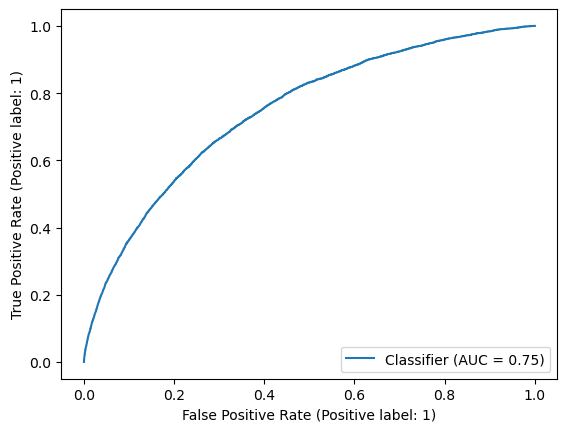

In [186]:
# Draw ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, base_model.predict_proba(X_test)[:, 1])

In [200]:
preds = base_model.predict_proba_all_models(X_train)
roc_auc_scores = [roc_auc_score(y_train, pred[:, 1]) for pred in preds]

In [201]:
roc_auc_scores

[0.7661949996337241,
 0.7755215981663821,
 0.7656664937464319,
 0.7616167828156091,
 0.7735039077627082]

In [202]:
preds = base_model.predict_proba_all_models(X_test)
roc_auc_scores = [roc_auc_score(y_test, pred[:, 1]) for pred in preds]
roc_auc_scores

[0.7425317203454178,
 0.7451113616632659,
 0.7422106280695151,
 0.7412553108317693,
 0.7429922730279716]

In [164]:
importance_dict = best_base_model.get_average_shap_feature_importance(X_train)

In [203]:
# Draw shap summary plot from the base_model get_average_shap_values
base_model_feature_importance = base_model.get_average_shap_feature_importance(X_train)


In [206]:
base_model_feature_importance.loc[base_model_feature_importance['feature'].str.contains('INCOME')]

,feature,importance
20,NAME_INCOME_TYPE,0.041141
34,ANNUITY_TO_INCOME,0.024391
44,INCOME_PER_FAM,0.015349
65,CREDIT_TO_INCOME,0.008411
126,AMT_INCOME_TOTAL,0.003574


In [207]:
X_train['NAME_INCOME_TYPE'].unique()

array(['Commercial associate', 'Working', 'Pensioner', 'State servant',
       'Unemployed', 'Businessman', 'Student', 'Maternity leave'],
      dtype=object)

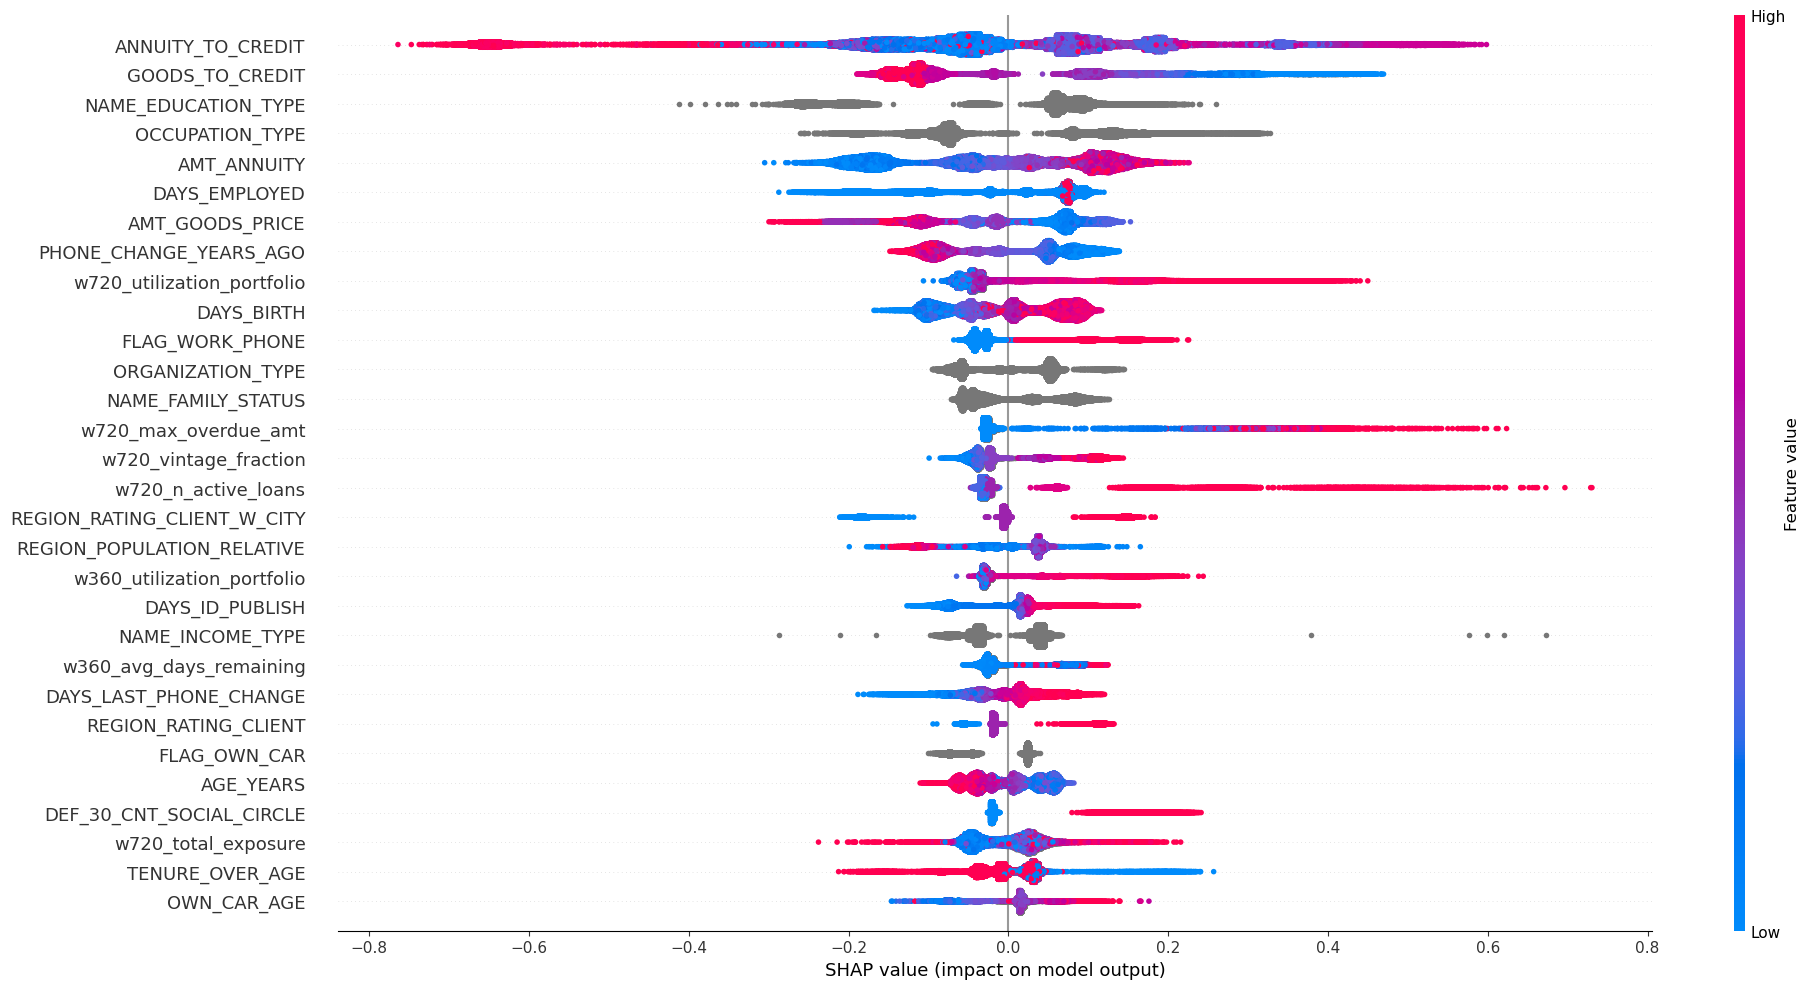

In [211]:
base_model.plot_shap_summary_plot(X_test, max_display=30, plot_size=(20,10))